## Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.




In [1]:
import csv
import numpy as np

from matplotlib import pyplot as plt

In [2]:
# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('../data/data.csv', delimiter=',') 
y = np.loadtxt('../data/labels.csv', delimiter=',')
with open('../data/feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]


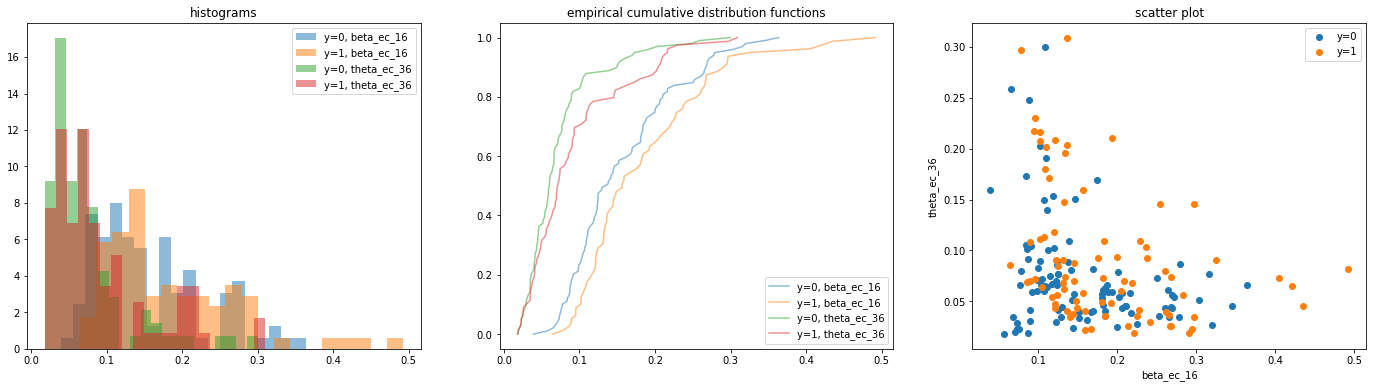

In [3]:
# plotting data in 2D with axes sampled 
# a) at random 
# b) from same electrode
# c) from same feature type
num_features = 9
num_electrodes = 48

# a) indices drawn at random
i0, i1 = np.random.randint(0, X.shape[1], size=2)

# b) same electrode, different feature (uncomment lines below)
#f0, f1 = np.random.randint(0, num_features, size=2)
#e = np.random.randint(0, num_electrodes)
#i0, i1 = f0*num_electrodes + e, f1*num_electrodes + e

# b) same feature, different electrode (uncomment lines below)
#f = np.random.randint(0, num_features)
#e0, e1 = np.random.randint(0, num_electrodes, size=2)
#i0, i1 = f*num_electrodes + e0, f*num_electrodes + e1

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = ['blue', 'red']

# select features i0, i1 and separate by class
X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
X10, X11 = X[y==0][:,i1], X[y==1][:,i1]
# plot cumulative distribution of feature i0 separate for each class
axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].set_title('histograms')
axes[0].legend()
axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
axes[1].set_title('empirical cumulative distribution functions')
axes[1].legend()
axes[2].scatter(X00, X10, label='y=0')
axes[2].scatter(X01, X11, label='y=1')
axes[2].set_xlabel(feature_names[i0])
axes[2].set_ylabel(feature_names[i1])
axes[2].set_title('scatter plot')
axes[2].legend()

### Import Libraries ###

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

### Hyperparameter Tuning ###

In [5]:
pipe_pca = Pipeline([('classifier' , RandomForestClassifier())])
pipe_skb = Pipeline([('classifier' , RandomForestClassifier())])

pca = PCA(0.99)
pca.fit(X)
X_pca = pca.transform(X)

skbest = SelectKBest(mutual_info_regression, k=200)
X_skb = skbest.fit_transform(X, y)


# Create param grid.
param_grid = [
    {
        'classifier' : [LogisticRegression()],
        'classifier__penalty' : ['l1', 'l2'],
        'classifier__max_iter' : [1000, 500, 200, 100],
        'classifier__C' : [100,10,5,1,0.1,0.01],
        'classifier__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    },    
    {
        'classifier' : [RandomForestClassifier()],
        'classifier__n_estimators' : list(range(10,101,10)),
        'classifier__max_features' : ['auto', 'sqrt', 'log2']
    },    
    {
        'classifier' : [RidgeClassifier()],
        'classifier__alpha' : list(np.array(range(1,11))/10.0),
        'classifier__solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    }
]

# Create grid search object
clf_pca = GridSearchCV(pipe_pca, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
clf_skb = GridSearchCV(pipe_skb, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data
best_clf_pca = clf_pca.fit(X_pca, y)
best_clf_skb = clf_skb.fit(X_skb, y)


Fitting 5 folds for each of 340 candidates, totalling 1700 fits


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
360 fits failed out of a total of 1700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\linear_model\_lo

Fitting 5 folds for each of 340 candidates, totalling 1700 fits


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
360 fits failed out of a total of 1700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\linear_model\_lo

In [6]:
print(best_clf_pca.best_params_)
print(best_clf_pca.best_score_)

print(best_clf_skb.best_params_)
print(best_clf_skb.best_score_)

{'classifier': LogisticRegression(C=100, max_iter=1000, penalty='l1', solver='liblinear'), 'classifier__C': 10, 'classifier__max_iter': 1000, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}
0.861111111111111
{'classifier': LogisticRegression(C=100, max_iter=1000, penalty='l1', solver='liblinear'), 'classifier__C': 100, 'classifier__max_iter': 1000, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.9111111111111111


In [7]:
# Calculates sensitivity and specificity
def calculate_Se_Sp(predictedOutput, actualOutput):
    tp, fn, fp, tn  = confusion_matrix(actualOutput,predictedOutput,labels=[0,1]).ravel()
    se = 1
    sp = 1
    if (tp+fn) != 0:
        se = tp / (tp+fn)
    if (tn+fp) != 0:
        sp = tn / (tn+fp)
    return se, sp

def cross_validate_leave_one_out_baseline(model, X, y):
    logo = LeaveOneGroupOut()
    y_test_list = []
    output_list = []
    ret = []
    se_list = []
    sp_list = []
    performance = []
    
    groups = []
    for i in range(180):
        groups.append(int(i/10)+1)
    
    
    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = np.array(X[train_index]), np.array(X[test_index])
        y_train, y_test = np.array(y[train_index]), np.array(y[test_index])
        
        clf = model.fit(X_train, y_train)
        output = model.predict(X_test)
        y_test_list = y_test_list + y_test.tolist()
        output_list = output_list + output.tolist()
        performance.append(model.score(X_test, y_test))
        se, sp = calculate_Se_Sp(output, y_test)
        se_list.append(se)
        sp_list.append(sp)

    auc = metrics.roc_auc_score(y_test_list, output_list)
    fpr, tpr, _ = metrics.roc_curve(np.array(y_test_list), np.array(output_list))
    ret = [ round(np.mean(performance), 4), round(np.mean(se_list), 4), round(np.mean(sp_list), 4), round(auc, 4), fpr, tpr ]
    
    return ret


def cross_validate_leave_one_out_PCA(model, X, y, percent):
    logo = LeaveOneGroupOut()
    y_test_list = []
    output_list = []
    ret = []
    se_list = []
    sp_list = []
    performance = []
    
    groups = []
    for i in range(180):
        groups.append(int(i/10)+1)
    
    pca = PCA(n_components=percent)
    
    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = np.array(X[train_index]), np.array(X[test_index])
        y_train, y_test = np.array(y[train_index]), np.array(y[test_index])

        pca.fit(X_train)
        X_train_pca = pca.transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        clf = model.fit(X_train_pca, y_train)
        output = model.predict(X_test_pca)
        y_test_list = y_test_list + y_test.tolist()
        output_list = output_list + output.tolist()
        performance.append(model.score(X_test_pca, y_test))
        se, sp = calculate_Se_Sp(output, y_test)
        se_list.append(se)
        sp_list.append(sp)

    auc = metrics.roc_auc_score(y_test_list, output_list)
    fpr, tpr, _ = metrics.roc_curve(np.array(y_test_list), np.array(output_list))
    ret = [ round(np.mean(performance), 4), round(np.mean(se_list), 4), round(np.mean(sp_list), 4), round(auc, 4), fpr, tpr ]
    
    return ret

def cross_validate_leave_one_out_SKB(model, X, y, n_features):
    logo = LeaveOneGroupOut()
    y_test_list = []
    output_list = []
    ret = []
    se_list = []
    sp_list = []
    performance = []
    
    groups = []
    for i in range(180):
        groups.append(int(i/10)+1)
        
    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = np.array(X[train_index]), np.array(X[test_index])
        y_train, y_test = np.array(y[train_index]), np.array(y[test_index])

        skbest = SelectKBest(k=n_features)
        train_X_reduced = skbest.fit_transform(X_train, y_train)
        test_X_reduced = skbest.transform(X_test)
        
        
        clf = model.fit(train_X_reduced, y_train)
        output = model.predict(test_X_reduced)
        y_test_list = y_test_list +  y_test.tolist()
        output_list = output_list +  output.tolist()
        se, sp = calculate_Se_Sp(output, y_test)
        se_list.append(se)
        sp_list.append(sp)
        performance.append(model.score(test_X_reduced, y_test))


    auc = metrics.roc_auc_score(y_test_list, output_list)
    fpr, tpr, _ = metrics.roc_curve(y_test_list, output_list)
    ret = [ round(np.mean(performance), 4), round(np.mean(se_list), 4), round(np.mean(sp_list), 4), round(auc, 4), fpr, tpr]

    return ret

def plot_graph(y,title):
    plt.xlim([10, len(y)+10])
    plt.ylim([0.0, 1.05])
    plt.yticks(np.arange(0, 1, step=0.1))
    plt.grid(True,axis='y')
    plt.title(title)
    #plot max value
    xmax = np.argmax(y)
    ymax = y[xmax]
    text= "x={:.3f}, y={:.3f}".format(xmax+10, ymax)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    plt.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)
    plt.plot(range(10,len(y)+10),y)
    plt.show()

In [8]:
results_LR = []

model = best_clf_pca.best_params_['classifier']
print("Model Selected: ", model)


print("\nBaseline :")

# Run cross-validation on model with PCA fearture extraction.
result_LR = cross_validate_leave_one_out_baseline(model, X, y)
print("Result : ", result_LR)
results_LR = results_LR + result_LR

Model Selected:  LogisticRegression(C=100, max_iter=1000, penalty='l1', solver='liblinear')

Baseline :
Result :  [0.8167, 0.9111, 0.9056, 0.8138, array([0.  , 0.16, 1.  ]), array([0.    , 0.7875, 1.    ])]


Accuracy :  [0.8167]
Specificity :  [0.9111]
Sensitivity :  [0.9056]
AUC :  [0.8138]


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


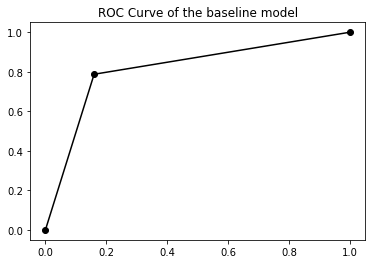

In [9]:
y_value = np.reshape(results_LR,(1,6))

print("Accuracy : ",y_value[:,0])
print("Specificity : ",y_value[:,1])
print("Sensitivity : ",y_value[:,2])
print("AUC : ",y_value[:,3])

i = np.argmax(y_value[:,3])
#for i in range(0,160):
plt.title("ROC Curve of the baseline model")
plt.plot(y_value[i,4],y_value[i,5],'ko', linestyle="-")

In [10]:
# Standardise the data
x = StandardScaler().fit_transform(X)

results_PCA_LR = []

model = best_clf_pca.best_params_['classifier']
print("Model Selected: ", model)

for num_features in range(10,170):
    print("\nNum_features :", num_features)
    
    # Run cross-validation on model with PCA fearture extraction.
    result_LR = cross_validate_leave_one_out_PCA(model, X, y, num_features)
    print("Result : ", result_LR[0:4])
    results_PCA_LR = results_PCA_LR + result_LR

    


Model Selected:  LogisticRegression(C=100, max_iter=1000, penalty='l1', solver='liblinear')

Num_features : 10
Result :  [0.7167, 0.8556, 0.8611, 0.7138]

Num_features : 11
Result :  [0.7222, 0.8722, 0.85, 0.7163]

Num_features : 12
Result :  [0.7167, 0.8722, 0.8444, 0.71]

Num_features : 13
Result :  [0.7111, 0.8611, 0.85, 0.7062]

Num_features : 14
Result :  [0.7111, 0.8611, 0.85, 0.7062]

Num_features : 15
Result :  [0.6889, 0.8389, 0.85, 0.6862]

Num_features : 16
Result :  [0.6889, 0.8444, 0.8444, 0.685]

Num_features : 17
Result :  [0.6944, 0.85, 0.8444, 0.69]

Num_features : 18
Result :  [0.6889, 0.8444, 0.8444, 0.685]

Num_features : 19
Result :  [0.6778, 0.8444, 0.8333, 0.6725]

Num_features : 20
Result :  [0.6667, 0.85, 0.8167, 0.6587]

Num_features : 21
Result :  [0.6556, 0.8444, 0.8111, 0.6475]

Num_features : 22
Result :  [0.7222, 0.8778, 0.8444, 0.715]

Num_features : 23
Result :  [0.7222, 0.8611, 0.8611, 0.7188]

Num_features : 24
Result :  [0.7333, 0.8722, 0.8611, 0.728

C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Result :  [0.7778, 0.9, 0.8778, 0.7725]

Num_features : 33


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Result :  [0.7889, 0.8944, 0.8944, 0.7863]

Num_features : 34


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Result :  [0.7833, 0.8944, 0.8889, 0.78]

Num_features : 35


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Result :  [0.8, 0.9056, 0.8944, 0.7962]

Num_features : 36


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\

Result :  [0.8111, 0.9167, 0.8944, 0.8062]

Num_features : 37


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\

Result :  [0.8556, 0.9333, 0.9222, 0.8525]

Num_features : 38


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\

Result :  [0.8222, 0.9167, 0.9056, 0.8188]

Num_features : 39


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\

Result :  [0.8167, 0.9222, 0.8944, 0.8112]

Num_features : 40


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\

Result :  [0.8222, 0.9222, 0.9, 0.8175]

Num_features : 41


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Result :  [0.85, 0.9444, 0.9056, 0.8438]

Num_features : 42
Result :  [0.8833, 0.9444, 0.9389, 0.8812]

Num_features : 43
Result :  [0.8556, 0.9278, 0.9278, 0.8538]

Num_features : 44
Result :  [0.8333, 0.9278, 0.9056, 0.8288]

Num_features : 45
Result :  [0.8389, 0.9278, 0.9111, 0.835]

Num_features : 46
Result :  [0.8556, 0.9333, 0.9222, 0.8525]

Num_features : 47
Result :  [0.8611, 0.9333, 0.9278, 0.8588]

Num_features : 48
Result :  [0.8556, 0.9333, 0.9222, 0.8525]

Num_features : 49
Result :  [0.8389, 0.9111, 0.9278, 0.8387]

Num_features : 50
Result :  [0.8389, 0.9056, 0.9333, 0.84]

Num_features : 51
Result :  [0.8333, 0.9056, 0.9278, 0.8337]

Num_features : 52
Result :  [0.85, 0.9167, 0.9333, 0.85]

Num_features : 53
Result :  [0.8444, 0.9111, 0.9333, 0.845]

Num_features : 54
Result :  [0.8556, 0.9222, 0.9333, 0.855]

Num_features : 55
Result :  [0.85, 0.9278, 0.9222, 0.8475]

Num_features : 56
Result :  [0.8333, 0.9222, 0.9111, 0.83]

Num_features : 57
Result :  [0.8333, 0.92

C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


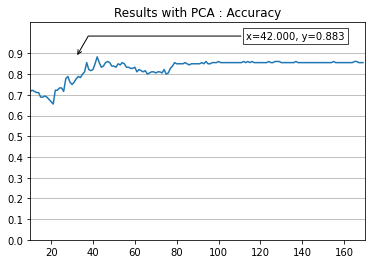

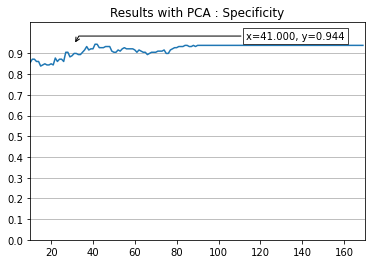

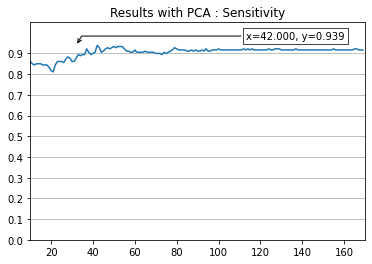

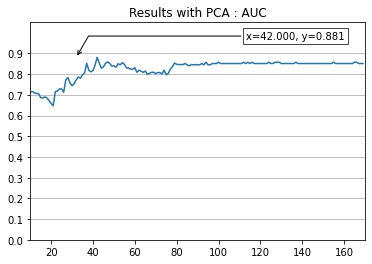

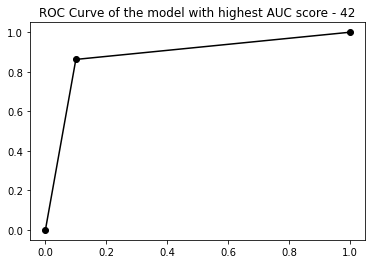

In [11]:
y_value = np.reshape(results_PCA_LR,(160,6))

plot_graph(y_value[:,0],"Results with PCA : Accuracy")
plot_graph(y_value[:,1],"Results with PCA : Specificity")
plot_graph(y_value[:,2],"Results with PCA : Sensitivity")
plot_graph(y_value[:,3],"Results with PCA : AUC")

i = np.argmax(y_value[:,3])
#for i in range(0,160):
plt.title("ROC Curve of the model with highest AUC score - %d"%(i+10))
plt.plot(y_value[i,4],y_value[i,5],'ko', linestyle="-")



In [12]:
results_SBK_LR = []
    
model = best_clf_skb.best_params_['classifier']
print("Model Selected: ", model)
for num_features in range(10,201):
    print("\nNum_features :", num_features)

    # Run cross-validation on model with SelectKBest fearture selection.
    result_LR = cross_validate_leave_one_out_SKB(model, X, y, num_features)
    print("Results : ", result_LR[0:4])
    
    results_SBK_LR = results_SBK_LR + result_LR
    

Model Selected:  LogisticRegression(C=100, max_iter=1000, penalty='l1', solver='liblinear')

Num_features : 10
Results :  [0.6778, 0.8722, 0.8056, 0.6662]

Num_features : 11
Results :  [0.6611, 0.8556, 0.8056, 0.6512]

Num_features : 12
Results :  [0.6889, 0.8778, 0.8111, 0.6775]

Num_features : 13
Results :  [0.7167, 0.8889, 0.8278, 0.7062]

Num_features : 14
Results :  [0.7333, 0.9111, 0.8222, 0.72]

Num_features : 15
Results :  [0.7222, 0.8889, 0.8333, 0.7125]

Num_features : 16
Results :  [0.7278, 0.8778, 0.85, 0.7213]

Num_features : 17
Results :  [0.7333, 0.8833, 0.85, 0.7263]

Num_features : 18
Results :  [0.7333, 0.8944, 0.8389, 0.7238]

Num_features : 19
Results :  [0.7333, 0.8944, 0.8389, 0.7238]

Num_features : 20
Results :  [0.7556, 0.8833, 0.8722, 0.7512]

Num_features : 21
Results :  [0.7444, 0.8778, 0.8667, 0.74]

Num_features : 22
Results :  [0.7444, 0.8778, 0.8667, 0.74]

Num_features : 23
Results :  [0.7556, 0.8778, 0.8778, 0.7525]

Num_features : 24
Results :  [0.761

Results :  [0.8667, 0.9389, 0.9278, 0.8638]

Num_features : 142
Results :  [0.8667, 0.9389, 0.9278, 0.8638]

Num_features : 143
Results :  [0.8667, 0.9389, 0.9278, 0.8638]

Num_features : 144
Results :  [0.8667, 0.9389, 0.9278, 0.8638]

Num_features : 145
Results :  [0.8722, 0.9444, 0.9278, 0.8688]

Num_features : 146
Results :  [0.8722, 0.9444, 0.9278, 0.8688]

Num_features : 147
Results :  [0.8722, 0.9444, 0.9278, 0.8688]

Num_features : 148
Results :  [0.8722, 0.9444, 0.9278, 0.8688]

Num_features : 149
Results :  [0.8722, 0.9444, 0.9278, 0.8688]

Num_features : 150
Results :  [0.8722, 0.9444, 0.9278, 0.8688]

Num_features : 151
Results :  [0.8667, 0.9389, 0.9278, 0.8638]

Num_features : 152
Results :  [0.8722, 0.9444, 0.9278, 0.8688]

Num_features : 153
Results :  [0.8722, 0.9444, 0.9278, 0.8688]

Num_features : 154
Results :  [0.8889, 0.9556, 0.9333, 0.885]

Num_features : 155
Results :  [0.8778, 0.9444, 0.9333, 0.875]

Num_features : 156
Results :  [0.8778, 0.9444, 0.9333, 0.875]

C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


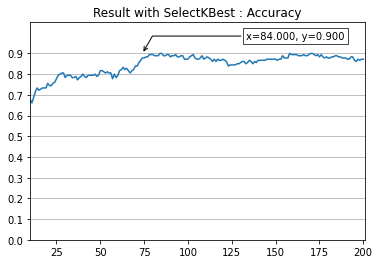

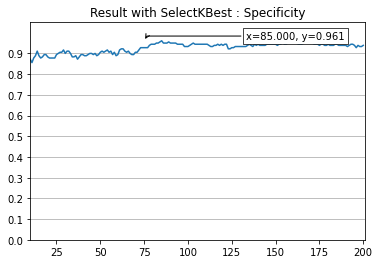

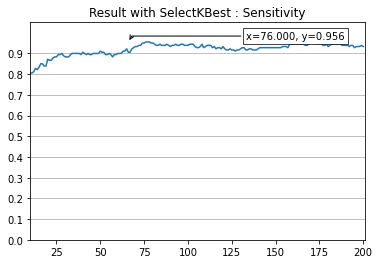

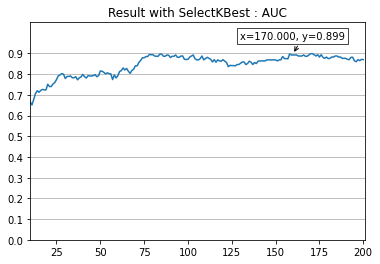

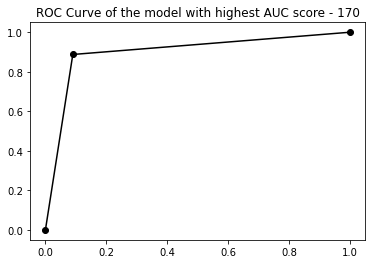

In [13]:
# Results of Logestic Regression
y_value = np.reshape(results_SBK_LR,(191,6))

plot_graph(y_value[:,0],"Result with SelectKBest : Accuracy")
plot_graph(y_value[:,1],"Result with SelectKBest : Specificity")
plot_graph(y_value[:,2],"Result with SelectKBest : Sensitivity")
plot_graph(y_value[:,3],"Result with SelectKBest : AUC")


i = np.argmax(y_value[:,3])
#for i in range(0,160):
plt.title("ROC Curve of the model with highest AUC score - %d"%(i+10))
plt.plot(y_value[i,4],y_value[i,5],'ko', linestyle="-")
